In [18]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
import random
import os
import warnings
import matplotlib.pyplot as plt # 득점모델 변수 중요도
import seaborn as sns

warnings.filterwarnings("ignore")

def visual_df(train):
    feature_selection = [f for f in train.columns if train[f].isnull().sum()<30000 and f != 'customer_country.1']
    train = train[feature_selection]
    feature_summary = pd.DataFrame(train.dtypes, columns=["Data Type"])
    feature_summary.reset_index(inplace=True)
    feature_summary.rename(columns={'index': 'Feature 이름'}, inplace=True)
    feature_summary['고유값 수'] = train.nunique().values
    feature_summary['결측값 수'] = train.isnull().sum().values
    return feature_summary
    

def seed_everything(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    
seed_everything()

def get_clf_eval(y_test, y_pred=None):

    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

def label_encoding(series):
    # """범주형 데이터를 시리즈 형태로 받아 숫자형 데이터로 변환합니다."""

    my_dict = {}
    # 모든 요소를 문자열로 변환
    mode = np.flip(series.value_counts().index.values)
    # unique value 찾고 아스키코드 기준으로 sort
    # my_dict을 통해 unique value에 대응하는 label 생성 
    for idx, value in enumerate(mode):
        my_dict[value] = idx
    # my_dict의 index와 매치되는 series값을 my_dict의 value로 변환한다.
    series = series.map(my_dict)

    return series

def same_word_detect(df, categorical_list):
    for feature in categorical_list:
        df[feature] = df[feature].str.lower()
        # 특수문자를 대체 문자열 지정
        replacement = {'/': '', 
                       '-':'', 
                       '_':'', 
                       ' ':'', 
                       '~':'',
                       '&':'',
                       '.':'',
                       ',':''}
        # replace() 함수를 사용하여 특수 문자 대체
        df[feature].replace(replacement, inplace=True)
    return df

def model_train(train, test, model):
    
    
    label_columns = [feature for feature in train.columns if train[feature].dtype=='O']
    label_columns.append('customer_idx')
    label_columns.append('lead_owner')

    df_all = pd.concat([train[label_columns], test[label_columns]])
    df_all = df_all.astype(str)
    df_all = same_word_detect(df_all, label_columns)
    temp = df_all
 
    
    # label encoding
    for col in label_columns:
        df_all[col] = label_encoding(df_all[col])
    # test set 분리 
    for col in label_columns:  
        train[col] = df_all.iloc[: len(train)][col]
        test[col] = df_all.iloc[len(train) :][col]

    x_train, x_val, y_train, y_val = train_test_split(
    train.drop("is_converted", axis=1),
    train["is_converted"],
    test_size=0.2,
    stratify=train["is_converted"],
    shuffle=True,
    random_state=42,)

    model = model
    model.fit(x_train.fillna(0), y_train)
    pred = model.predict(x_val.fillna(0))
    metrics = get_clf_eval(y_val, pred)
    print(metrics)

    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index=x_train.columns)
    ftr_top = ftr_importances.sort_values(ascending=False)[:20]
    print(ftr_top[:5])
    plt.figure(figsize=(8, 6))
    sns.barplot(x=ftr_top, y=ftr_top.index)
    plt.show()
    return model, metrics, df_all

오차행렬:
 [[  707   263]
 [   37 10853]]

정확도: 0.9747
정밀도: 0.9503
재현율: 0.7289
F1: 0.8250
None
customer_idx               0.329546
lead_owner                 0.096299
historical_existing_cnt    0.078377
lead_desc_length           0.054954
customer_job               0.046311
dtype: float64


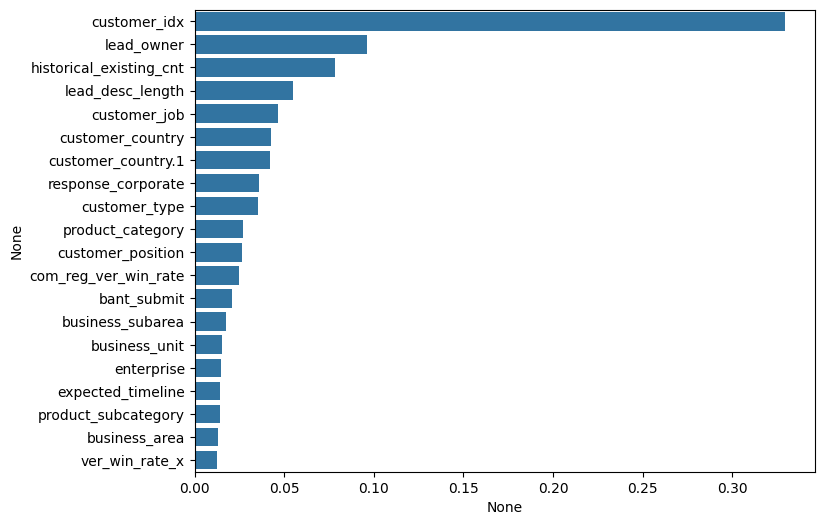

In [19]:
from sklearn.ensemble import RandomForestClassifier

train = pd.read_csv('/home/workspace/LGamiers/EDA/train.csv')
test = pd.read_csv("/home/workspace/LGamiers/Model/submission.csv")
model = RandomForestClassifier()
model, metrics, df_all = model_train(train, test, model)

오차행렬:
 [[  709   261]
 [   32 10858]]

정확도: 0.9753
정밀도: 0.9568
재현율: 0.7309
F1: 0.8288
None
customer_idx        0.394893
lead_owner          0.131022
lead_desc_length    0.086284
customer_country    0.077062
customer_job        0.069602
dtype: float64


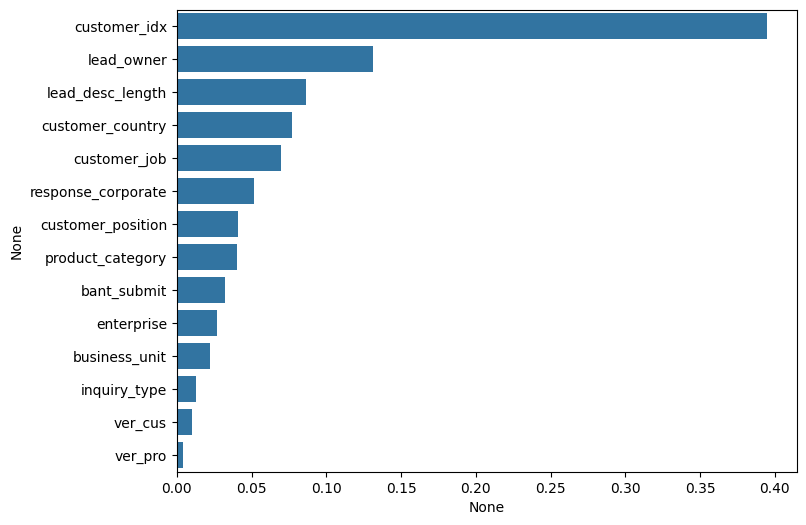

In [20]:
from sklearn.ensemble import RandomForestClassifier

train = pd.read_csv('/home/workspace/LGamiers/EDA/train.csv')
test = pd.read_csv("/home/workspace/LGamiers/Model/submission.csv")
feature_selection = [f for f in train.columns if train[f].isnull().sum()<30000 and f != 'customer_country.1']
train = train[feature_selection]
test = test[feature_selection]
model = RandomForestClassifier()
model, metrics, temp = model_train(train, test, model)